### Importing and data Loading
In the first step we import all necessary libraries and load the data from the csv files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.ndimage import gaussian_filter1d
import zipfile
import os
import glob
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier


In [2]:
full_df=pd.read_csv('C://Users//Bavana Pasupuleti//Downloads//archive (1)//harth//S025.csv')

In [3]:
full_df['label'].unique()

array([  3,   6,   1,   7,   8,   5,   2,  14,  13, 140, 130,   4],
      dtype=int64)

### Handling Missing Values
First we tried to check if there are any missing values, since there aren't any we tried dropping the columns that are extra.

In [4]:
#columns with null values
print('Data columns with null values:',full_df.isnull().sum(), sep = '\n')
print(full_df.columns)
#dropping any unncesary columns
def drop_columns_if_exist(full_df, columns):

    for column in columns:
        if column in full_df.columns:
            full_df = full_df.drop(columns=[column])
    return full_df
columns_to_drop = ['Unnamed: 0','index'] 

# Drop columns if they exist
full_df = drop_columns_if_exist(full_df, columns_to_drop)

Data columns with null values:
timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64
Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label'],
      dtype='object')


### Outlier Detection and Removal

In [5]:
from scipy import stats
# Calculate Z-scores of the data
z_scores = np.abs(stats.zscore(full_df.select_dtypes(include=[np.number])))

# Define the outlier threshold
outlier_threshold = 3

# Identify and remove outliers
outliers = (z_scores > outlier_threshold).any(axis=1)
full_df3 = full_df[(z_scores < outlier_threshold).all(axis=1)]

# Display the shape of the DataFrame before and after outlier removal
print(f"DataFrame shape before outlier removal: {full_df.shape}")
print(f"DataFrame shape after outlier removal: {full_df3.shape}")

DataFrame shape before outlier removal: (231729, 8)
DataFrame shape after outlier removal: (209763, 8)


### Normalisation and Noise Reduction

In [6]:
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

# List of sensor columns to apply noise reduction and normalization because these play a major role in the prediction
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Apply Gaussian filter for noise reduction
for col in sensor_columns:
    full_df[col + '_smoothed'] = gaussian_filter1d(full_df[col], sigma=2)

# Normalize data to have a consistent scale across different sensors
scaler = MinMaxScaler()
full_df[sensor_columns] = scaler.fit_transform(full_df[sensor_columns])


Here we have plotted a sample graph to show how the data points have been effected after normalisation and scaling

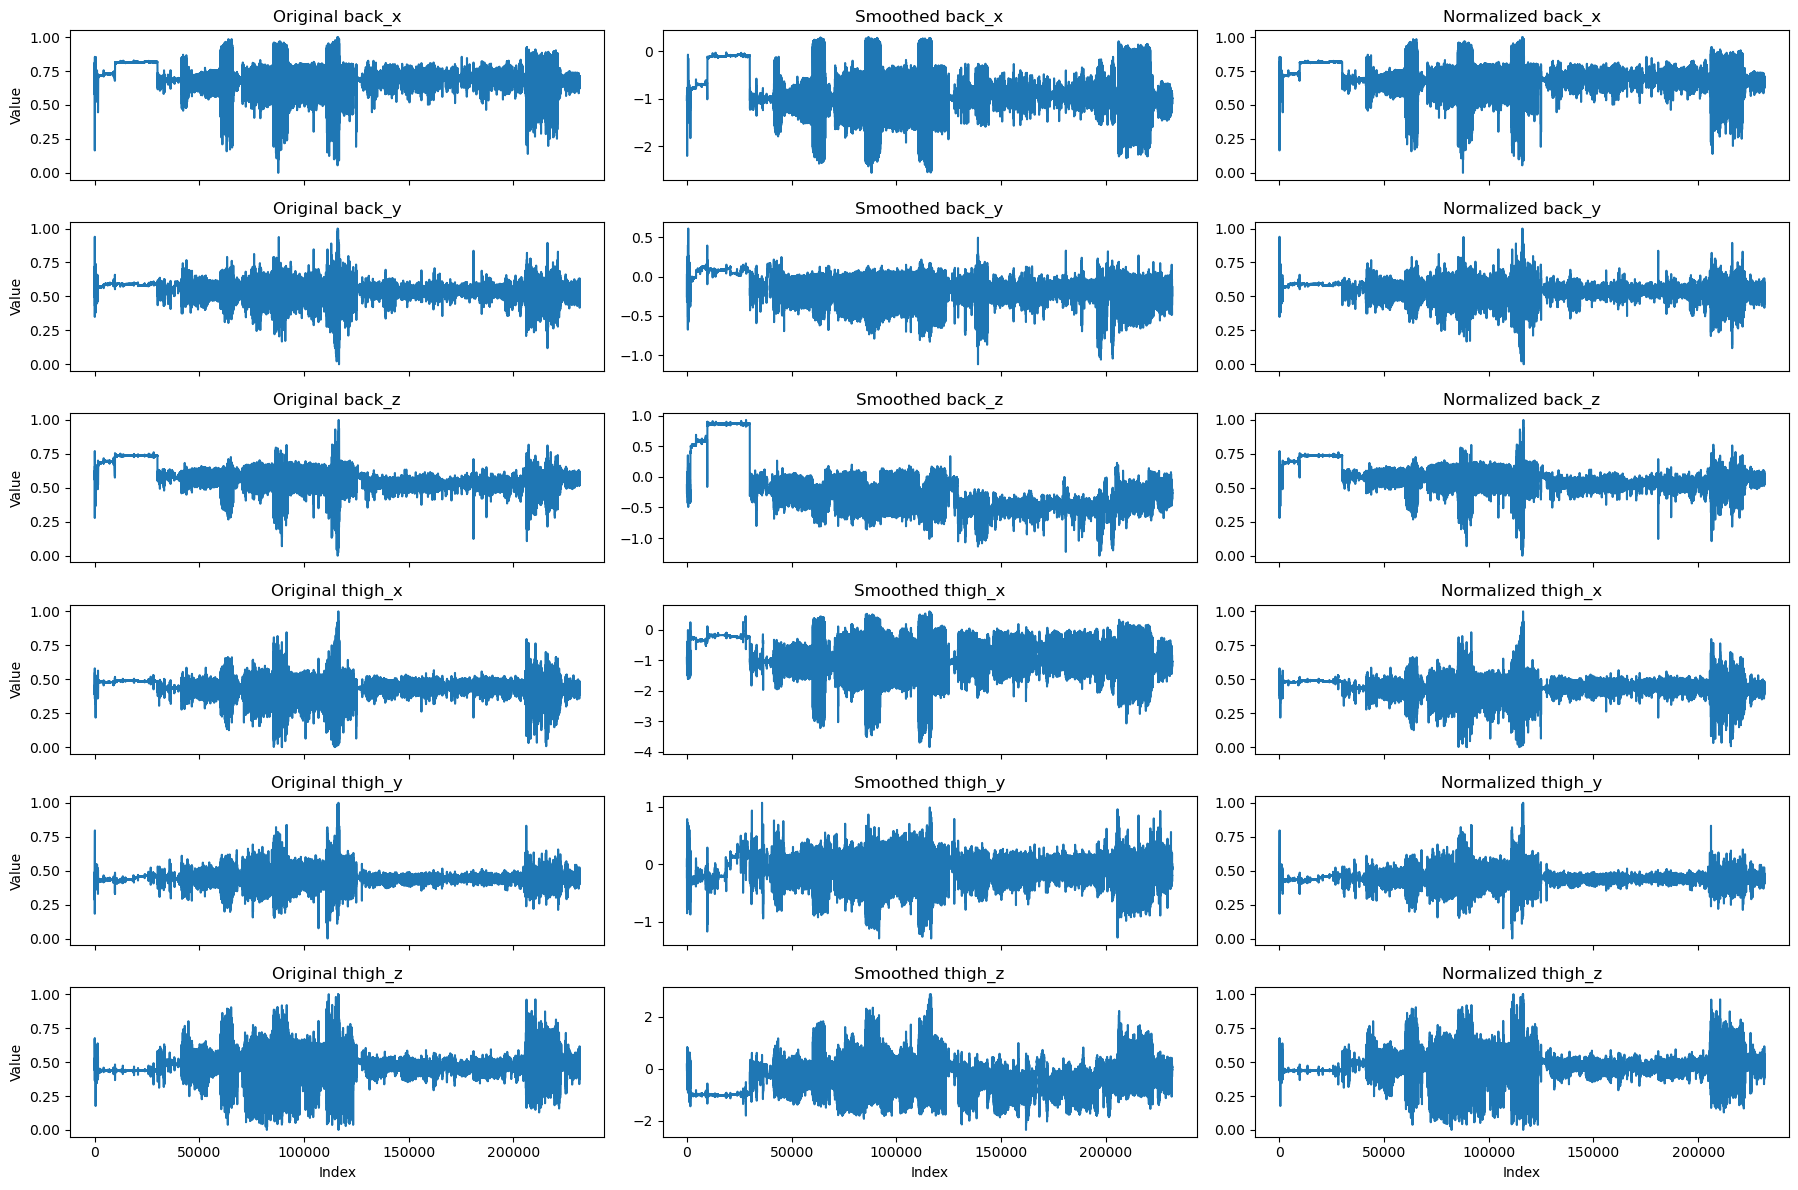

In [7]:
def plot_data_comparison(df, original_columns, smoothed_columns, normalized_columns):
    fig, axes = plt.subplots(len(original_columns), 3, figsize=(18, 12), sharex=True)

    for i, col in enumerate(original_columns):
        axes[i, 0].plot(df.index, df[col])
        axes[i, 0].set_title(f'Original {col}')
        axes[i, 0].set_ylabel('Value')

        axes[i, 1].plot(df.index, df[smoothed_columns[i]])
        axes[i, 1].set_title(f'Smoothed {col}')

        axes[i, 2].plot(df.index, df[normalized_columns[i]])
        axes[i, 2].set_title(f'Normalized {col}')

    for ax in axes[-1, :]:
        ax.set_xlabel('Index')

    plt.tight_layout()
    plt.show()

# Define columns for plotting
smoothed_columns = [col + '_smoothed' for col in sensor_columns]
normalized_columns = sensor_columns

# Plot the data comparisons
plot_data_comparison(full_df, sensor_columns, smoothed_columns, normalized_columns)

### Feature Selection

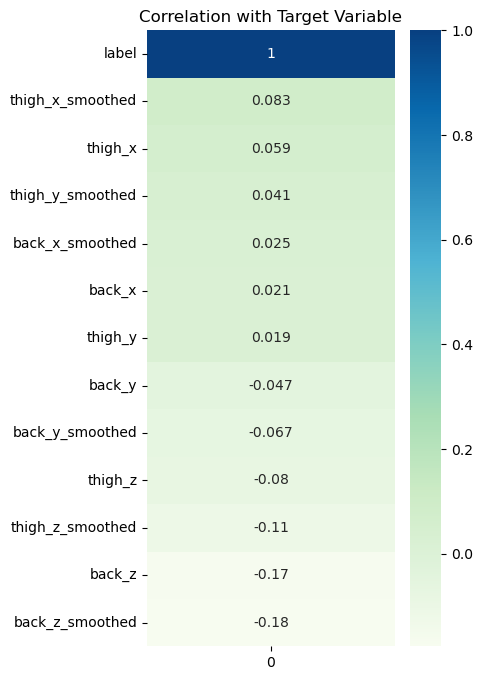

In [8]:
# Drop non-numeric columns for correlation calculation
numeric_df = full_df.select_dtypes(include=['float64', 'int64'])
target_variable = full_df['label']
# Create a correlation matrix with target variable
corr_with_target =numeric_df.corrwith(target_variable)

# Sort features by correlation with target variable
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

### Feature Engineering

In [9]:
# Set the window size for rolling mean
window_size = 5

# Calculate the rolling mean for 'back_x' and 'thigh_x' columns
full_df['back_x_rolling_mean'] = full_df['back_x_smoothed'].rolling(window=window_size, min_periods=1).mean()
full_df['thigh_x_rolling_mean'] = full_df['thigh_x_smoothed'].rolling(window=window_size, min_periods=1).mean()

# Print the updated data structure
print('Updated Data Structure After Feature Engineering:')
full_df.info()

Updated Data Structure After Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231729 entries, 0 to 231728
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp             231729 non-null  object 
 1   back_x                231729 non-null  float64
 2   back_y                231729 non-null  float64
 3   back_z                231729 non-null  float64
 4   thigh_x               231729 non-null  float64
 5   thigh_y               231729 non-null  float64
 6   thigh_z               231729 non-null  float64
 7   label                 231729 non-null  int64  
 8   back_x_smoothed       231729 non-null  float64
 9   back_y_smoothed       231729 non-null  float64
 10  back_z_smoothed       231729 non-null  float64
 11  thigh_x_smoothed      231729 non-null  float64
 12  thigh_y_smoothed      231729 non-null  float64
 13  thigh_z_smoothed      231729 non-null  float64
 14  ba

### Data Segmentation

In [10]:
# Function to segment the data
def segment_data(data, window_size, overlap):
    segments = []
    labels = []
    step = int(window_size * (1 - overlap))
    for start in range(0, len(data) - window_size + 1, step):
        end = start + window_size
        segment = data.iloc[start:end]
        segments.append(segment[sensor_columns].values)
        labels.append(segment['label'].mode()[0])  # Use the mode (most common label) as the segment label
    return np.array(segments), np.array(labels)

window_size = 100  # Example window size
overlap = 0.5  # 50% overlap
X_segments, y_segments = segment_data(full_df, window_size, overlap)

# Flatten the segments for model input
n_samples, n_steps, n_features = X_segments.shape
X = X_segments.reshape((n_samples, n_steps * n_features))
Y = pd.Series(y_segments)


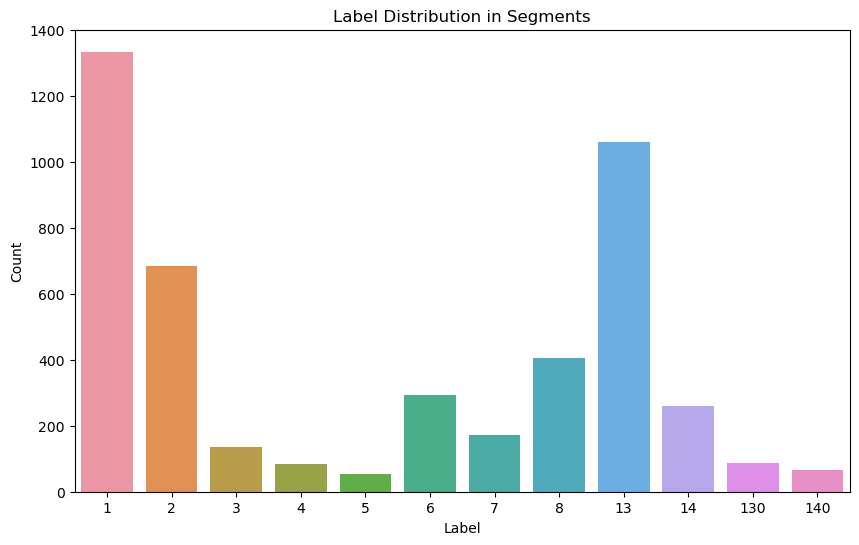

In [11]:
import seaborn as sns

def plot_label_distribution(labels):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=labels)
    plt.title('Label Distribution in Segments')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Plot label distribution
plot_label_distribution(y_segments)


### Splitting the data into Train and Test 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_segments, test_size=0.2, random_state=42)
print("Input Training:",X_train.shape)
print("Input Test:",X_test.shape)
print("Output Training:",y_train.shape)
print("Output Test:",y_test.shape)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

Input Training: (3706, 600)
Input Test: (927, 600)
Output Training: (3706,)
Output Test: (927,)
X_train shape: (3706, 600)
X_test shape: (927, 600)


### Basic Models

In [13]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('\n')


Decision Tree Accuracy: 0.8004
              precision    recall  f1-score   support

           1       0.88      0.84      0.86       269
           2       0.95      0.90      0.92       148
           3       0.18      0.21      0.19        24
           4       0.20      0.38      0.26        13
           5       0.09      0.11      0.10         9
           6       0.76      0.77      0.77        57
           7       0.91      0.95      0.93        44
           8       1.00      1.00      1.00        90
          13       0.86      0.79      0.82       196
          14       0.51      0.57      0.54        46
         130       0.32      0.44      0.37        16
         140       0.39      0.47      0.42        15

    accuracy                           0.80       927
   macro avg       0.59      0.62      0.60       927
weighted avg       0.82      0.80      0.81       927

[[227   5  11  10   7   2   1   0   2   2   1   1]
 [  2 133   0   1   0   2   1   0   3   5   1   0]


Decision Tree Performance:
  Accuracy: 0.8047
  F1 Score: 0.8124
  Precision: 0.8228
  Recall: 0.8047


KNN Performance:
  Accuracy: 0.8544
  F1 Score: 0.8598
  Precision: 0.8893
  Recall: 0.8544


SVM Performance:
  Accuracy: 0.8889
  F1 Score: 0.8521
  Precision: 0.8204
  Recall: 0.8889


Random Forest Performance:
  Accuracy: 0.9105
  F1 Score: 0.8870
  Precision: 0.8868
  Recall: 0.9105


Naive Bayes Performance:
  Accuracy: 0.7875
  F1 Score: 0.8134
  Precision: 0.8703
  Recall: 0.7875


               Accuracy  F1 Score  Precision    Recall
Decision Tree  0.804746  0.812403   0.822795  0.804746
KNN            0.854369  0.859805   0.889304  0.854369
SVM            0.888889  0.852095   0.820439  0.888889
Random Forest  0.910464  0.887048   0.886751  0.910464
Naive Bayes    0.787487  0.813356   0.870264  0.787487


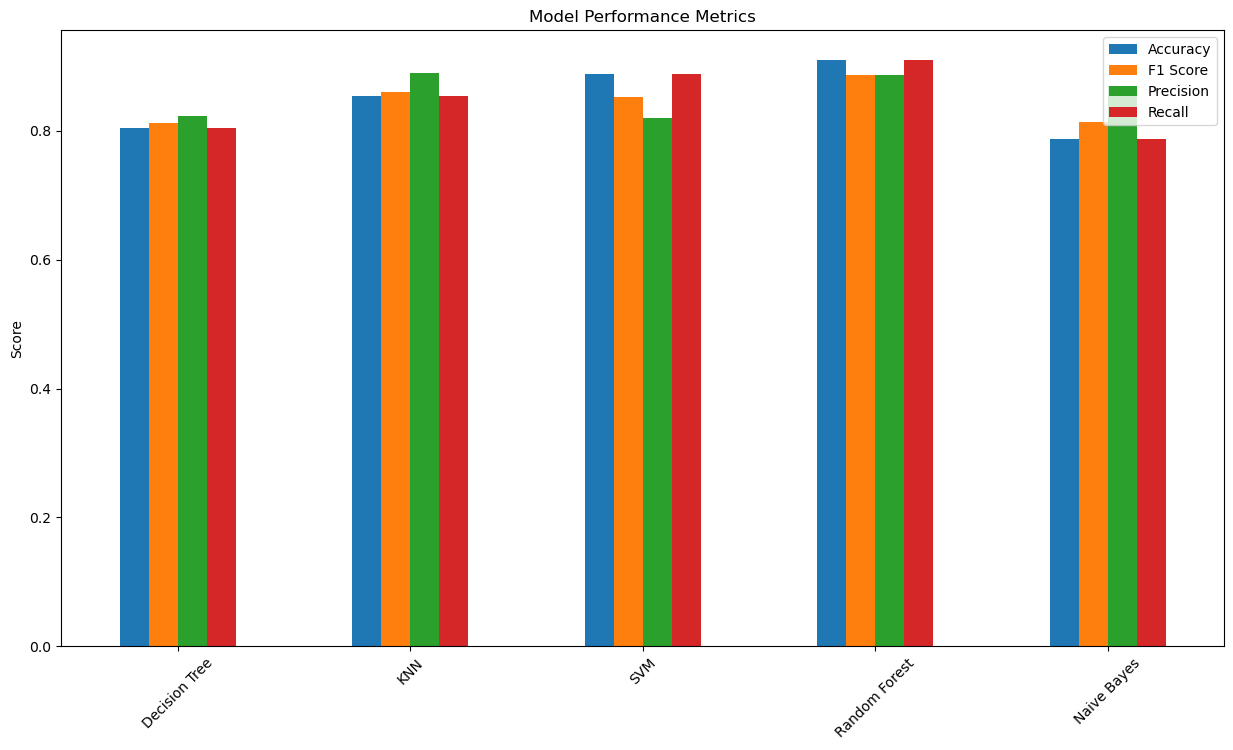

In [14]:
# Summarize and visualize performance metrics
metrics_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    }

# Print evaluation metrics
for name, metrics in metrics_results.items():
    print(f'{name} Performance:')
    for metric, score in metrics.items():
        print(f'  {metric}: {score:.4f}')
    print('\n')

# Display performance metrics
metrics_df = pd.DataFrame(metrics_results).T
print(metrics_df)

# Visualize metrics
metrics_df.plot(kind='bar', figsize=(15, 8))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

Voting Classifier Accuracy: 0.9213
              precision    recall  f1-score   support

           1       0.95      0.96      0.95       269
           2       1.00      1.00      1.00       148
           3       0.36      0.21      0.26        24
           4       0.91      0.77      0.83        13
           5       1.00      0.56      0.71         9
           6       0.76      0.96      0.85        57
           7       1.00      0.95      0.98        44
           8       1.00      1.00      1.00        90
          13       0.96      0.95      0.95       196
          14       0.86      0.80      0.83        46
         130       0.50      0.69      0.58        16
         140       0.53      0.53      0.53        15

    accuracy                           0.92       927
   macro avg       0.82      0.78      0.79       927
weighted avg       0.92      0.92      0.92       927

[[257   0   9   1   0   2   0   0   0   0   0   0]
 [  0 148   0   0   0   0   0   0   0   0   0  

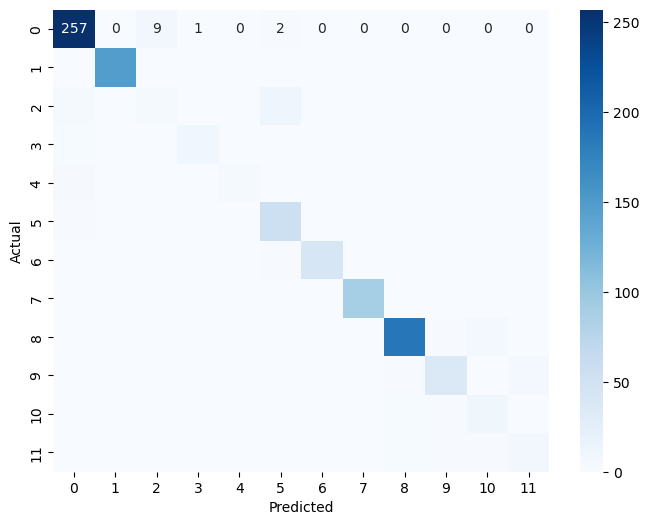

In [17]:
# Create and train Voting Classifier with soft voting
voting_clf = VotingClassifier(estimators=[
    ('dt', models['Decision Tree']),
    ('knn', models['KNN']),
    ('svm', models['SVM']),
    ('rf', models['Random Forest']),
    ('nb', models['Naive Bayes'])
], voting='soft')

voting_clf.fit(X_train, y_train)

# Evaluate Voting Classifier
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Voting Classifier Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### ANN

In [20]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the ANN model
ann_model = Sequential()
ann_model.add(Dense(256, input_dim=X_train.shape[1], activation='elu'))  # Increased units
ann_model.add(Dropout(0.5))  # Dropout to prevent overfitting
ann_model.add(Dense(128, activation='elu'))  # Increased units
ann_model.add(Dropout(0.5))
ann_model.add(Dense(64, activation='elu'))  # Increased units
ann_model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
# Train the model
history_ann = ann_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2820 - loss: -1264.4641 - val_accuracy: 0.2817 - val_loss: -24615.7656
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2894 - loss: -64407.6250 - val_accuracy: 0.2817 - val_loss: -476178.8438
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2828 - loss: -751382.5625 - val_accuracy: 0.2817 - val_loss: -3106389.5000
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2930 - loss: -3963944.7500 - val_accuracy: 0.2817 - val_loss: -11596411.0000
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2856 - loss: -13192487.0000 - val_accuracy: 0.2817 - val_loss: -32504592.0000
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2864 - loss: -36328784.0000 - val_accuracy: 0.2817 - val_loss: -74239864.0000
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2923 - loss: -76225968.0000 - val_accuracy: 0.2817 - val_loss: -145684400.0000
Epoch 8/100
4

In [22]:
# Evaluate the model
loss, accuracy = ann_model.evaluate(X_test, y_test)
print(f'ANN Test Loss: {loss:.4f}')
print(f'ANN Test Accuracy: {accuracy:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2938 - loss: -2747558789120.0000
ANN Test Loss: -2697390981120.0000
ANN Test Accuracy: 0.2902


### RNN-LSTM Model- Definition

In [23]:
#model definition
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the RNN-LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))  # Adjust units and activation based on your label encoding
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change loss if using multi-class
    return model


# Reshape X_train and X_test to be compatible with LSTM input
X_train_lstm = X_train.reshape((X_train.shape[0], window_size, len(sensor_columns)))
X_test_lstm = X_test.reshape((X_test.shape[0], window_size, len(sensor_columns)))

input_shape = (window_size, len(sensor_columns))

# Create the model
lstm_model = create_lstm_model(input_shape)

# Print model summary
lstm_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

### RNN Model Building

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Select relevant columns
sensor_columns = [
    'back_x_smoothed', 'back_y_smoothed', 'back_z_smoothed',
    'thigh_x_smoothed', 'thigh_y_smoothed', 'thigh_z_smoothed'
]

engineered_columns = ['back_x_rolling_mean', 'thigh_x_rolling_mean']



# Separate features and target
X_sensors = full_df[sensor_columns].values
X_engineered = full_df[engineered_columns].values
y = full_df['label'].values

# One-hot encode the target variable
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.reshape(-1, 1))

# Standardize the sensor data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sensors)

# Define the window size for the RNN
timesteps = 198  # Update based on your sequence length
features = len(sensor_columns)  # Number of sensor columns
samples = len(X_scaled) // timesteps

# Reshape the sensor data for RNN input
X_reshaped = X_scaled[:samples * timesteps].reshape((samples, timesteps, features))
y_reshaped = y_encoded[:samples * timesteps:timesteps]

# Split the reshaped data into training and testing sets
X_train, X_test, X_eng_train, X_eng_test, y_train, y_test = train_test_split(
    X_reshaped, X_engineered[:samples], y_reshaped, test_size=0.3, random_state=42)

# Define the RNN model
def create_simplified_rnn_model(timesteps, features, engineered_features_shape, num_classes):
    # Sensor data input
    sensor_input = Input(shape=(timesteps, features), name='sensor_input')
    x = LSTM(units=32)(sensor_input)  # Simplified LSTM layer
    rnn_output = Dropout(0.2)(x)  # Simplified dropout

    # Input for engineered features
    features_input = Input(shape=(engineered_features_shape,), name='features_input')

    # Combine RNN output with engineered features
    combined = Concatenate()([rnn_output, features_input])
    x = Dense(64, activation='relu')(combined)  # Simplified dense layer
    output = Dense(num_classes, activation='softmax')(x)

    # Model definition
    model = Model(inputs=[sensor_input, features_input], outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the simplified RNN model
simplified_rnn_model = create_simplified_rnn_model(timesteps, features, X_engineered.shape[1], y_train.shape[1])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_simplified_rnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the simplified RNN model
history = simplified_rnn_model.fit(
    [X_train, X_eng_train], y_train,
    validation_data=([X_test, X_eng_test], y_test),
    epochs=75,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
y_pred_prob = simplified_rnn_model.predict([X_test, X_eng_test])
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test_labels, y_pred))
print(confusion_matrix(y_test_labels, y_pred))


Epoch 1/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.0539 - loss: 2.5757 - val_accuracy: 0.3362 - val_loss: 2.3224
Epoch 2/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3745 - loss: 2.2611 - val_accuracy: 0.6125 - val_loss: 1.9835
Epoch 3/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.5849 - loss: 1.9072 - val_accuracy: 0.6211 - val_loss: 1.5728
Epoch 4/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5961 - loss: 1.5192 - val_accuracy: 0.6182 - val_loss: 1.2965
Epoch 5/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6125 - loss: 1.2463 - val_accuracy: 0.6325 - val_loss: 1.2370
Epoch 6/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6024 - loss: 1.3104 - val_accuracy: 0.6439 - val_loss: 1.2056
Epoch 7/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6398 - loss: 1.1388 - val_accuracy: 0.6553 - val_loss: 1.1338
Epoch 8/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6818 - loss: 1.0760 - val_accuracy: 0.678

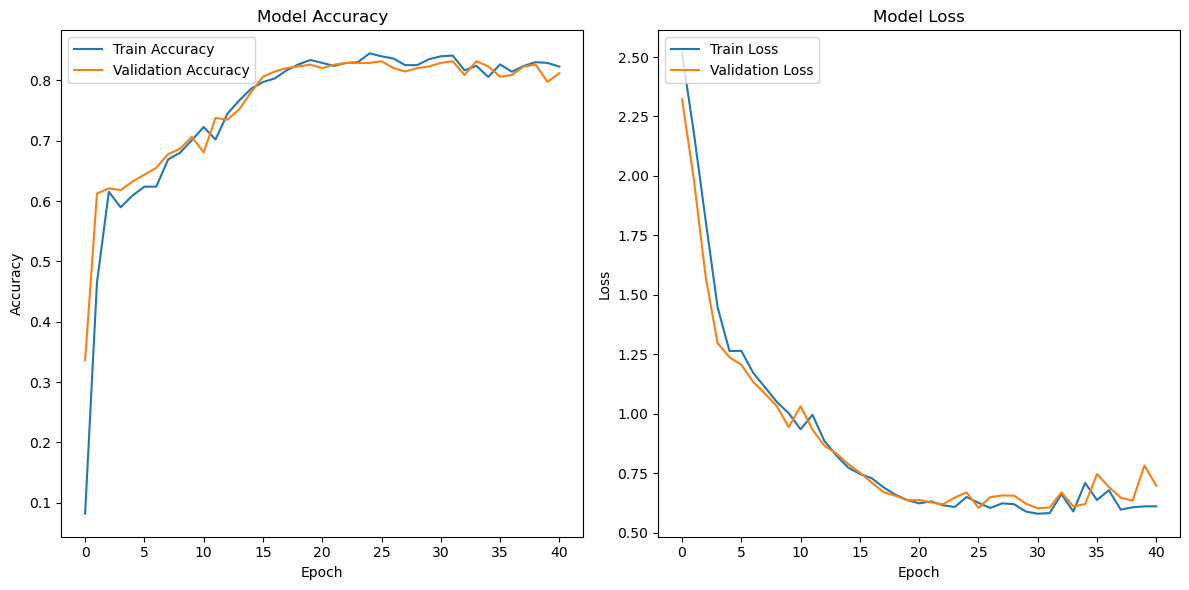

In [25]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
rnn_accuracy = history.history['val_accuracy'][-1]
results['RNN'] = rnn_accuracy

### Model Comparison

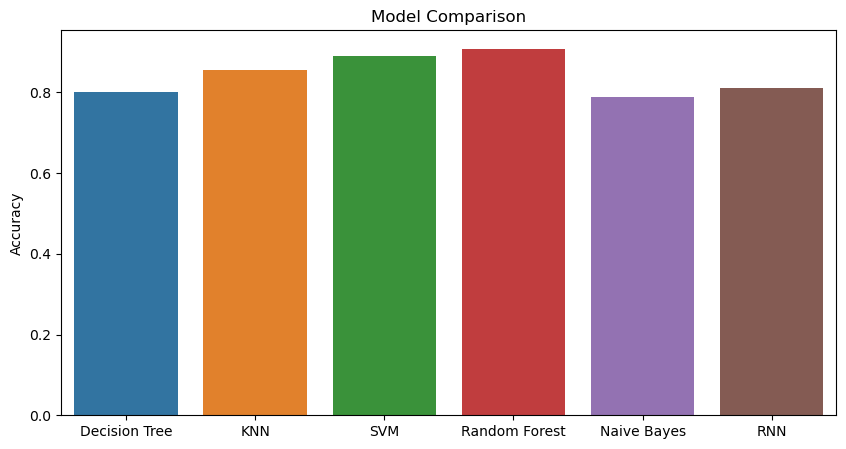

In [27]:
# Plotting the models
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.show()

### 10 fold cross validation

In [28]:
from sklearn.model_selection import KFold

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Flatten data for traditional models
X_flattened = X.reshape(X.shape[0], -1)

# Initialize a dictionary to store cross-validation results
cv_results = {}

# Perform cross-validation for traditional models
for name, model in models.items():
    fold_accuracies = []
    for train_index, val_index in kf.split(X_flattened):
        X_train_fold, X_val_fold = X_flattened[train_index], X_flattened[val_index]
        y_train_fold, y_val_fold = y_segments[train_index], y_segments[val_index]
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        fold_accuracies.append(accuracy)
    cv_results[name] = fold_accuracies
    print(f'{name} 10-Fold CV Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})')


Decision Tree 10-Fold CV Accuracy: 0.8107 (+/- 0.0147)
KNN 10-Fold CV Accuracy: 0.8547 (+/- 0.0176)
SVM 10-Fold CV Accuracy: 0.8744 (+/- 0.0121)
Random Forest 10-Fold CV Accuracy: 0.9057 (+/- 0.0096)
Naive Bayes 10-Fold CV Accuracy: 0.8010 (+/- 0.0188)


In [29]:
cv_results
cv_results1=cv_results

In [30]:
# Reshape or adjust y_train to match X_train_lstm
# For example, if y_train needs to be reshaped to fit the sequence data

num_samples = X_train_lstm.shape[0]  # Number of samples in X_train_lstm

# Ensure y_train has the same number of samples
# Example adjustment (if appropriate based on how y_train was generated):
y_train = np.resize(y_train, (num_samples, y_train.shape[1]))  # Adjust as needed


In [39]:
X_train_cv = np.array(X_train_cv)
X_eng_train_cv = np.array(X_eng_train_cv)
y_train_cv = np.array(y_train_cv)

X_test_cv = np.array(X_test_cv)
X_eng_test_cv = np.array(X_eng_test_cv)
y_test_cv = np.array(y_test_cv)


In [46]:
# Ensure all arrays have the same number of samples in the training set
min_train_samples = min(X_train_cv.shape[0], X_eng_train_cv.shape[0], y_train_cv.shape[0])

# Slice the training arrays to have the same number of samples
X_train_cv = X_train_cv[:min_train_samples]
X_eng_train_cv = X_eng_train_cv[:min_train_samples]
y_train_cv = y_train_cv[:min_train_samples]

# Ensure all arrays have the same number of samples in the test set
min_test_samples = min(X_test_cv.shape[0], X_eng_test_cv.shape[0], y_test_cv.shape[0])

# Slice the test arrays to have the same number of samples
X_test_cv = X_test_cv[:min_test_samples]
X_eng_test_cv = X_eng_test_cv[:min_test_samples]
y_test_cv = y_test_cv[:min_test_samples]

# Now create the TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'sensor_input': X_train_cv, 'features_input': X_eng_train_cv}, y_train_cv))

test_dataset = tf.data.Dataset.from_tensor_slices(
    ({'sensor_input': X_test_cv, 'features_input': X_eng_test_cv}, y_test_cv))


In [47]:
print(X_train_cv.shape)
print(X_eng_train_cv.shape)
print(y_train_cv.shape)

(819, 198, 6)
(819, 2)
(819, 12)


In [41]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Assuming X_train_cv and y_train_cv are numpy arrays or tensors
X_train_cv = np.array(X_train_cv)
y_train_cv = np.array(y_train_cv)

# Convert y_train_cv to categorical if needed
num_classes = y_train_cv.shape[1]  # Number of output classes
y_train_cv = to_categorical(np.argmax(y_train_cv, axis=1), num_classes=num_classes)

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold = 1
accuracies = []

for train_index, val_index in kf.split(X_train_cv):
    X_train_fold, X_val_fold = X_train_cv[train_index], X_train_cv[val_index]
    y_train_fold, y_val_fold = y_train_cv[train_index], y_train_cv[val_index]

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train_fold)).batch(64)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    val_dataset = val_dataset.batch(64)

    # Define the model
    model = Sequential([
        LSTM(64, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]), return_sequences=True),
        LSTM(32),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=75,
        batch_size=64,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    accuracies.append(val_accuracy)
    
    print(f'Fold {fold} - Validation Accuracy: {val_accuracy:.4f}')
    fold += 1

print(f'Mean Accuracy across folds: {np.mean(accuracies):.4f}')
print(f'Standard Deviation of Accuracy across folds: {np.std(accuracies):.4f}')


Epoch 1/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.2700 - loss: 2.3677 - val_accuracy: 0.4878 - val_loss: 2.1251
Epoch 2/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.5982 - loss: 1.8851 - val_accuracy: 0.5244 - val_loss: 1.6837
Epoch 3/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.6113 - loss: 1.3751 - val_accuracy: 0.5000 - val_loss: 1.5228
Epoch 4/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5994 - loss: 1.2551 - val_accuracy: 0.6220 - val_loss: 1.3284
Epoch 5/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.7495 - loss: 1.0060 - val_accuracy: 0.6829 - val_loss: 1.1418
Epoch 6/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.7897 - loss: 0.8107 - val_accuracy: 0.6951 - val_loss: 1.0843
Epoch 7/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.8233 - loss: 0.7124 - val_accuracy: 0.7317 - val_loss: 1.0408
Epoch 8/75
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.7986 - loss: 0.7192 - val_accuracy: 0.

In [42]:
cv_results['RNN']=val_accuracy

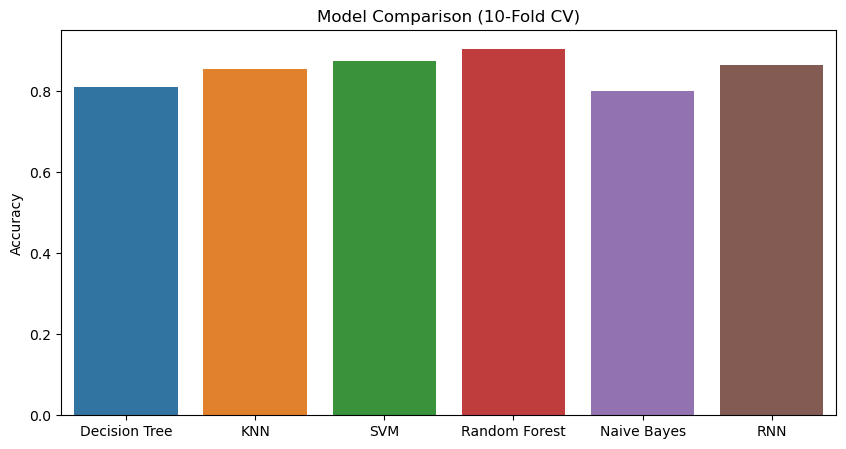

In [43]:
# Plotting the models
plt.figure(figsize=(10, 5))
sns.barplot(x=list(cv_results.keys()), y=[np.mean(scores) for scores in cv_results.values()])
plt.title('Model Comparison (10-Fold CV)')
plt.ylabel('Accuracy')
plt.show()

### Summary 

From the above analysis we can conclude that Random Forest Classifier has the highest accuracy

back_x and thigh_x are the most important features from the dataset

More the number of epochs more the accuracy in RNN's

On the wholw we can use RandomForest Classifier to predict the labels accurately

RNN will show the highest accuracy if trained on more data and more layers

None of the models are overfitted and the accuracy remained same before and after 